In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from IPython.display import display
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [12]:
ticker_symbol = "AAPL"

In [13]:
def win(stock_data, window):
    close = stock_data['Close']
    windowed_closing_values = []
    
    for i in range(len(close)):
        labels = []
        labels.append(stock_data.index[i])
        for j in range(window + 1):
            if i - j >= 0: 
                labels.append(close.values[i - (-j + window)])
            else:
                labels.append(None)
        windowed_closing_values.append(labels)

    windowed_closing_values = pd.DataFrame(windowed_closing_values)
    windowed_closing_values.drop(windowed_closing_values.index[:window], inplace=True)

    labels = ["-" + str(window -i) + "d" for i in range(window)]
    labels = ["Label Date"] + labels + ["Label"]

    windowed_closing_values.columns = labels
    return windowed_closing_values

In [14]:
def date_X_y_split(windowed_closing_values, window):
    dates = windowed_closing_values.iloc[0]

    np_array = windowed_closing_values.iloc[:, 1:].to_numpy(dtype=np.float64)

    dates = windowed_closing_values.iloc[:, 0].to_numpy()

    X = np_array[:, :-1].reshape(len(np_array), window, 1)
    y = np_array[:, -1]
    
    return dates, X, y

In [15]:
def train_and_graph(days, window):
    stock_data = yf.download(ticker_symbol, period= str(days)+"d")
    windowed_closing_values = win(stock_data, window)
    
    dates, X, y = date_X_y_split(windowed_closing_values, window)

    d_80 = int(len(dates) * 0.8)
    d_90 = int(len(dates) * 0.9)
    dates_train, X_train, y_train = dates[:d_80], X[:d_80], y[:d_80]
    dates_val, X_val, y_val = dates[d_80:d_90], X[d_80:d_90], y[d_80:d_90]
    dates_test, X_test, y_test = dates[d_90:], X[d_90:], y[d_90:]

    model = Sequential([layers.Input((window, 1)),
                        layers.LSTM(64),
                        layers.Dense(32, activation = 'relu'),
                        layers.Dense(32, activation = 'relu'),
                        layers.Dense(1)])

    model.compile(loss='mse', optimizer = Adam(learning_rate=0.001), metrics = ['mean_absolute_error'])
    model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)

    test_predictions = model.predict(X_test).flatten() 
    plt.plot(dates_test, y_test)
    plt.plot(dates_test, test_predictions)
    plt.legend(["Validation Labels", "Test Predictions"])

[*********************100%***********************]  1 of 1 completed

Epoch 1/100


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 56548.1562 - mean_absolute_error: 237.5735 - val_loss: 57649.1016 - val_mean_absolute_error: 240.0666
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 56173.7539 - mean_absolute_error: 236.8058 - val_loss: 57515.5391 - val_mean_absolute_error: 239.7882
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 55954.7344 - mean_absolute_error: 236.3348 - val_loss: 57412.1484 - val_mean_absolute_error: 239.5725
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 56146.7070 - mean_absolute_error: 236.7416 - val_loss: 57321.4375 - val_mean_absolute_error: 239.3831
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 56057.8594 - mean_absolute_error: 236.5589 - val_loss: 57234.1328 - val_mean_absolute_error: 239.2007
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 56145.1328 - mean_absolute_error: 236.7368 - val_loss: 57141.6484 - val_mean_absolute_error: 239.0073
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - 

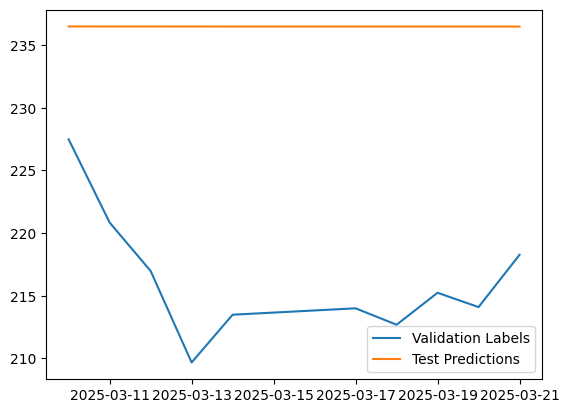

In [ ]:
train_and_graph(365, 3)